In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

runs_metadata = {}

def readfile(fn):
    lines = []
    
    with open(fn) as fp:
        lines = fp.readlines()
    
    metadata = eval(lines[0])
    for run_n, run_conf in metadata['steps_conf'].items():
        runs_metadata[run_n] = run_conf
    
    rows = []
    
    for line in lines[1:]:
        row = eval(line.strip())
        if row['step_n'] is not None and row['step_n'] != -1:
            if row['step_n']%2 != 0:
                row['step_n'] -= 1
            #row['speed'] = metadata['steps_conf'][row['step_n']]
            rows.append(row)
    
    d = pd.DataFrame(
        [[r['timestamp'], r['step_n'], r['packages']] for r in rows], columns=["ts", "n", "dict"]
    )
    d["n"] = pd.to_numeric(d["n"])
    #d["dict"] = d["dict"].map(eval)
    df = d.groupby("n").apply(readrun)
    #df['user'] = ['user']*len(df)
    return df

def readrun(df):
    frames = {}
    for _, r in df.iterrows():
        frames[r["ts"]] = pd.DataFrame(r["dict"].values())
    df = pd.concat(frames, names=["ts", "box"]).reset_index()
    df["ts"] = pd.to_datetime(df["ts"])
    return df.set_index(["ts", "box"])



In [7]:
log_path = "./logs_VR"


In [8]:
log_files = list(sorted(glob(f"{log_path}/*.txt")))

In [10]:
data = []
alldata = {}
for log_file in tqdm(log_files):
    print(log_file)
    df = readfile(log_file)
    alldata[log_file] = df

  0%|          | 0/12 [00:00<?, ?it/s]

./logs_VR/2021-09-06T16:07:34_gabri_0.txt
./logs_VR/2021-09-06T16:23:06_gabri_1.txt
./logs_VR/2021-09-06T16:29:21_gabri_2.txt
./logs_VR/2021-09-06T16:37:49_gabri_3.txt
./logs_VR/2021-09-08T10:06:08_jerome_0.txt
./logs_VR/2021-09-08T10:12:21_jerome_1.txt
./logs_VR/2021-09-08T10:17:12_jerome_2.txt
./logs_VR/2021-09-08T10:21:49_jerome_3.txt
./logs_VR/2021-09-08T11:59:31_anto_0.txt
./logs_VR/2021-09-08T12:04:40_anto_1.txt
./logs_VR/2021-09-08T12:09:35_anto_2.txt
./logs_VR/2021-09-08T12:13:52_anto_3.txt


In [11]:
adf = pd.concat(alldata, axis=0, names=["fn"]).reset_index()

In [12]:
import pathlib
def parsefn(x):
    x = pathlib.Path(x)
    _, user, _ = x.stem.split("_")
    return pd.Series(
        dict(user=user)
    )


adf = pd.concat((adf, adf["fn"].apply(parsefn)), axis=1)

In [13]:
adf

,fn,n,ts,box,uid,position,type,length,selected,user
0,./logs_VR/2021-09-06T16:07:34_gabri_0.txt,0,2021-09-06 16:08:05.256972288,0,1.0,"(belt_d, 0.0005000000237487257)",1.0,1.2,False,gabri
1,./logs_VR/2021-09-06T16:07:34_gabri_0.txt,0,2021-09-06 16:08:05.256972288,1,2.0,"(belt_c, 0.0005000001401640475)",1.0,1.2,False,gabri
2,./logs_VR/2021-09-06T16:07:34_gabri_0.txt,0,2021-09-06 16:08:05.256972288,2,3.0,"(belt_b, 0.0002905334113165736)",1.0,1.2,False,gabri
3,./logs_VR/2021-09-06T16:07:34_gabri_0.txt,0,2021-09-06 16:08:05.256972288,3,0.0,"(belt_a, 0.00043580008787103)",1.0,1.2,False,gabri
4,./logs_VR/2021-09-06T16:07:34_gabri_0.txt,0,2021-09-06 16:08:05.357084160,0,1.0,"(belt_d, 0.003000000026077032)",1.0,1.2,False,gabri
...,...,...,...,...,...,...,...,...,...,...
134880,./logs_VR/2021-09-08T12:13:52_anto_3.txt,38,2021-09-08 12:18:04.627795456,0,441.0,"(belt_a, 0.8832215070724487)",1.0,1.2,False,anto
134881,./logs_VR/2021-09-08T12:13:52_anto_3.txt,38,2021-09-08 12:18:04.727845376,0,441.0,"(belt_a, 0.9122748970985413)",1.0,1.2,False,anto
134882,./logs_VR/2021-09-08T12:13:52_anto_3.txt,38,2021-09-08 12:18:04.827943168,0,441.0,"(belt_a, 0.9384228587150574)",1.0,1.2,False,anto
134883,./logs_VR/2021-09-08T12:13:52_anto_3.txt,38,2021-09-08 12:18:04.927879656,0,441.0,"(belt_a, 0.9674761891365051)",1.0,1.2,False,anto


In [14]:
adf['dt'] = adf.groupby(["n", "uid", "user"])["ts"].transform(lambda x: x - x.iloc[0])
adf["target"] = adf["type"] == 0.0
adf["correct"] = adf["target"] == adf["selected"]

In [15]:
def generate_runs(df):
    runs = []
    for (run_n, uid, user), p in df:
        p = p.reset_index()
        sel_idx = p['selected'].astype('bool').argmax()

        run = {
              'uid': int(uid),
              'user': user,
              'type': p['type'].loc[0], 
              'sel_dt': p['dt'].loc[sel_idx], 
              'selected': p['selected'].loc[sel_idx],
              'target': p['target'].loc[0],
              'correct': p['correct'].loc[sel_idx],
              'run_n': run_n,
              'speed': runs_metadata[run_n]['speed']}
        runs.append(run)
    return pd.DataFrame(runs)

In [16]:
grouped_df = adf.groupby(["n", "uid", "user"])
all_runs_df = generate_runs(grouped_df)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set_style("ticks")
sns.color_palette("Set2")
figwidth = 5

In [18]:
all_runs_df['sel_dt'] = all_runs_df['sel_dt'].dt.total_seconds()

### Average selection times for all users separated, single plot

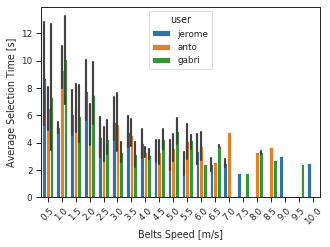

In [44]:
corr_sel_time = all_runs_df[(all_runs_df["correct"] == True) & (all_runs_df["target"] == True)]
# corr_sel_time['sel_dt'] = corr_sel_time['sel_dt'].dt.total_seconds()

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=corr_sel_time,
    x="speed",
    y="sel_dt",
#     palette = "viridis",
    hue="user",
    estimator=np.mean,
#     ci=90,
#     order=scenarios,
#     hue_order=interfaces,
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)
ax.set(ylabel="Average Selection Time [s]", xlabel="Belts Speed [m/s]")
fig.savefig("avg_sel_time.png", dpi=300)
fig.savefig("avg_sel_time.pdf", dpi=300)

### Average selection times, means between users for each speed

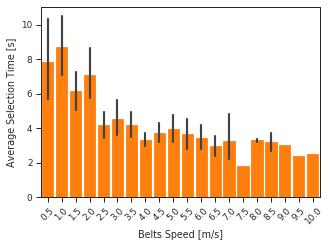

In [19]:
corr_sel_time = all_runs_df[(all_runs_df["correct"] == True) & (all_runs_df["target"] == True)]
# corr_sel_time['sel_dt'] = corr_sel_time['sel_dt'].dt.total_seconds()

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=corr_sel_time,
    x="speed",
    y="sel_dt",
    palette = "viridis",
#     hue="user",
    estimator=np.mean,
#     ci=90,
#     order=scenarios,
#     hue_order=interfaces,
    ax=ax,
)
for i, bar in enumerate(ax.patches):
    bar.set_color("C1")

ax.tick_params(axis='x', rotation=45)
ax.set(ylabel="Average Selection Time [s]", xlabel="Belts Speed [m/s]")
fig.savefig("agg_avg_sel_time.png", dpi=300, bbox_inches='tight')
fig.savefig("agg_avg_sel_time.pdf", dpi=300, bbox_inches='tight')

### Average selection times, means between users for each speed (binned)

In [20]:
speeds = np.unique(all_runs_df['speed'])
labels = [i for i in range(1, 11)]
# labels = [f"[{speeds[i]}, {speeds[i+1]}]" for i in range(0, len(speeds)-1, 2)]
all_runs_df['speed_bin'] = pd.cut(all_runs_df['speed'], bins=10, labels=labels)

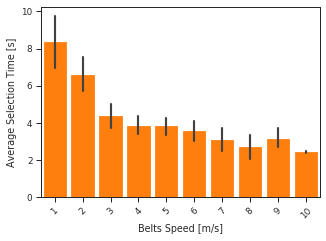

In [21]:
corr_sel_time = all_runs_df[(all_runs_df["correct"] == True) & (all_runs_df["target"] == True)]
# corr_sel_time['sel_dt'] = corr_sel_time['sel_dt'].dt.total_seconds()

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=corr_sel_time,
    x="speed_bin",
    y="sel_dt",
    palette = "viridis",
#     hue="user",
    estimator=np.mean,
#     ci=90,
#     order=scenarios,
#     hue_order=interfaces,
    ax=ax,
)
for i, bar in enumerate(ax.patches):
    bar.set_color("C1")

ax.tick_params(axis='x', rotation=45)
ax.set(ylabel="Average Selection Time [s]", xlabel="Belts Speed [m/s]")
fig.savefig("bin_avg_sel_time.png", dpi=300, bbox_inches='tight')
fig.savefig("bin_avg_sel_time.pdf", dpi=300, bbox_inches='tight')

### Average selection times for all users separated, one plot per user

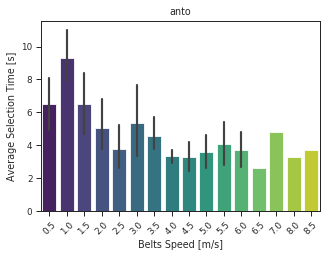

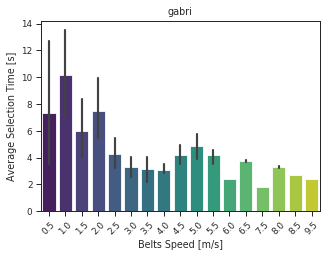

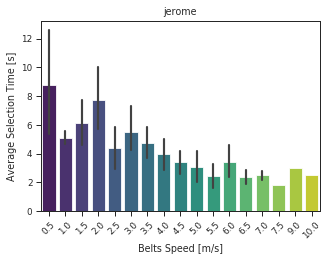

In [22]:
for user in np.unique(all_runs_df["user"]):
    corr_sel_time = all_runs_df[(all_runs_df["correct"] == True) 
                                & (all_runs_df["target"] == True)
                                & (all_runs_df["user"] == user)]
#     corr_sel_time['sel_dt'] = corr_sel_time['sel_dt'].dt.total_seconds()

    fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
    sns.barplot(
        data=corr_sel_time,
        x="speed",
        y="sel_dt",
        palette = "viridis",
#         hue="user",
        estimator=np.mean,
    #     ci=90,
    #     order=scenarios,
    #     hue_order=interfaces,
        ax=ax,
    )
    ax.tick_params(axis='x', rotation=45)
    ax.set(ylabel="Average Selection Time [s]", xlabel="Belts Speed [m/s]", title=f"{user}")
    fig.savefig(f"{user}_avg_sel_time.png", dpi=300)
    fig.savefig(f"{user}_avg_sel_time.pdf", dpi=300)

In [23]:
def get_total_correct(df):
    return df['correct'].sum()/len(df)

def get_defect_correct(df):
    df = df[df['target'] == True]
    return df['correct'].sum()/len(df)


### % of Defect Packages Selected for all users separated, single plot

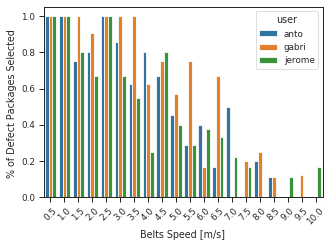

In [52]:
total_correct = all_runs_df.groupby('speed').apply(get_total_correct).to_frame('perc_of_sel').reset_index()
defect_correct = all_runs_df.groupby(['speed', 'user']).apply(get_defect_correct).to_frame('perc_of_sel').reset_index()

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=defect_correct,
    x="speed",
    y="perc_of_sel",
#     palette = "viridis",
    hue="user",
#     estimator=np.mean,
#     ci=90,
#     order=scenarios,
#     hue_order=interfaces,
    ax=ax,
)
ax.set(ylabel="% of Defect Packages Selected ", xlabel="Belts Speed [m/s]")
ax.tick_params(axis='x', rotation=45)
fig.savefig("percentage_of_selected.png", dpi=300)
fig.savefig("percentage_of_selected.pdf", dpi=300)

### % of Defect Packages Selected for all users separated, mean between users for each speed

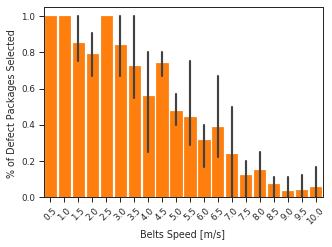

In [61]:
total_correct = all_runs_df.groupby('speed').apply(get_total_correct).to_frame('perc_of_sel').reset_index()
defect_correct = all_runs_df.groupby(['speed', 'user']).apply(get_defect_correct).to_frame('perc_of_sel').reset_index()

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=defect_correct,
    x="speed",
    y="perc_of_sel",
#     palette = "viridis",
#     hue="user",
    estimator=np.mean,
#     ci=90,
#     order=scenarios,
#     hue_order=interfaces,
    ax=ax,
)
for i, bar in enumerate(ax.patches):
    bar.set_color("C1")
ax.set(ylabel="% of Defect Packages Selected ", xlabel="Belts Speed [m/s]")
ax.tick_params(axis='x', rotation=45)

fig.savefig("agg_percentage_of_selected.png", dpi=300, bbox_inches='tight')
fig.savefig("agg_percentage_of_selected.pdf", dpi=300, bbox_inches='tight')

### % of Defect Packages Selected for all users separated, mean between users for each speed (binned)

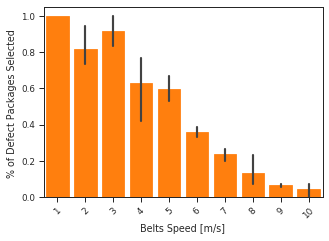

In [24]:
total_correct = all_runs_df.groupby('speed_bin').apply(get_total_correct).to_frame('perc_of_sel').reset_index()
defect_correct = all_runs_df.groupby(['speed_bin', 'user']).apply(get_defect_correct).to_frame('perc_of_sel').reset_index()

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=defect_correct,
    x="speed_bin",
    y="perc_of_sel",
#     palette = "viridis",
#     hue="user",
    estimator=np.mean,
#     ci=90,
#     order=scenarios,
#     hue_order=interfaces,
    ax=ax,
)
for i, bar in enumerate(ax.patches):
    bar.set_color("C1")
ax.set(ylabel="% of Defect Packages Selected ", xlabel="Belts Speed [m/s]")
ax.tick_params(axis='x', rotation=45)

fig.savefig("bin_percentage_of_selected.png", dpi=300, bbox_inches='tight')
fig.savefig("bin_percentage_of_selected.pdf", dpi=300, bbox_inches='tight')

### % of Defect Packages Selected for all users separated, one plot for each user

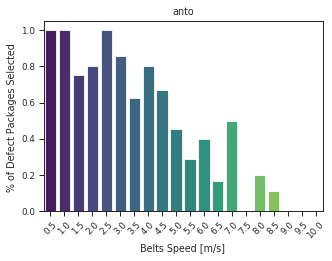

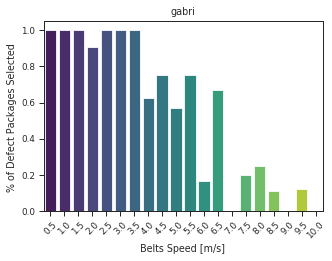

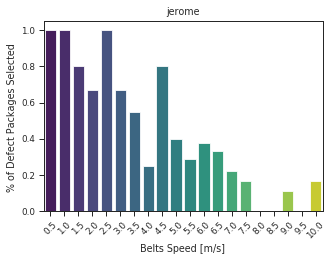

In [26]:
for user in np.unique(all_runs_df["user"]):
    total_correct = all_runs_df[all_runs_df["user"]==user].groupby('speed').apply(get_total_correct).to_frame('perc_of_sel').reset_index()
    defect_correct = all_runs_df[all_runs_df["user"]==user].groupby('speed').apply(get_defect_correct).to_frame('perc_of_sel').reset_index()

    fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
    sns.barplot(
        data=defect_correct,
        x="speed",
        y="perc_of_sel",
        palette = "viridis",
    #     hue="user",
    #     estimator=np.mean,
    #     ci=90,
    #     order=scenarios,
    #     hue_order=interfaces,
        ax=ax,
    )
    ax.set(ylabel="% of Defect Packages Selected ", xlabel="Belts Speed [m/s]", title=f"{user}")
    ax.tick_params(axis='x', rotation=45)
    fig.savefig(f"{user}_percentage_of_selected.png", dpi=300)
    fig.savefig(f"{user}_percentage_of_selected.pdf", dpi=300)